### Metrica IO

In [0]:
import pandas as pd
import csv as csv

def read_match_data(DATADIR,gameid):
    '''
    read_match_data(DATADIR,gameid):
    read all Metrica match data (tracking data for home & away teams, and ecvent data)
    '''
    tracking_home = tracking_data(DATADIR,gameid,'Home')
    tracking_away = tracking_data(DATADIR,gameid,'Away')
    events = read_event_data(DATADIR,gameid)
    return tracking_home,tracking_away,events

def read_event_data(DATADIR,game_id):
    '''
    read_event_data(DATADIR,game_id):
    read Metrica event data  for game_id and return as a DataFrame
    '''
    eventfile = '/Sample_Game_%d/Sample_Game_%d_RawEventsData.csv' % (game_id,game_id) # filename
    events = pd.read_csv('{}/{}'.format(DATADIR, eventfile)) # read data
    return events

def tracking_data(DATADIR,game_id,teamname):
    '''
    tracking_data(DATADIR,game_id,teamname):
    read Metrica tracking data for game_id and return as a DataFrame. 
    teamname is the name of the team in the filename. For the sample data this is either 'Home' or 'Away'.
    '''
    teamfile = '/Sample_Game_%d/Sample_Game_%d_RawTrackingData_%s_Team.csv' % (game_id,game_id,teamname)
    # First:  deal with file headers so that we can get the player names correct
    csvfile =  open('{}/{}'.format(DATADIR, teamfile), 'r') # create a csv file reader
    reader = csv.reader(csvfile) 
    teamnamefull = next(reader)[3].lower()
    print("Reading team: %s" % teamnamefull)
    # construct column names
    jerseys = [x for x in next(reader) if x != ''] # extract player jersey numbers from second row
    columns = next(reader)
    for i, j in enumerate(jerseys): # create x & y position column headers for each player
        columns[i*2+3] = "{}_{}_x".format(teamname, j)
        columns[i*2+4] = "{}_{}_y".format(teamname, j)
    columns[-2] = "ball_x" # column headers for the x & y positions of the ball
    columns[-1] = "ball_y"
    # Second: read in tracking data and place into pandas Dataframe
    tracking = pd.read_csv('{}/{}'.format(DATADIR, teamfile), names=columns, index_col='Frame', skiprows=3)
    return tracking

def merge_tracking_data(home,away):
    '''
    merge home & away tracking data files into single data frame
    '''
    return home.drop(columns=['ball_x', 'ball_y']).merge( away, left_index=True, right_index=True )
    
def to_metric_coordinates(data,field_dimen=(106.,68.) ):
    '''
    Convert positions from Metrica units to meters (with origin at centre circle)
    '''
    x_columns = [c for c in data.columns if c[-1].lower()=='x']
    y_columns = [c for c in data.columns if c[-1].lower()=='y']
    data[x_columns] = ( data[x_columns]-0.5 ) * field_dimen[0]
    data[y_columns] = -1 * ( data[y_columns]-0.5 ) * field_dimen[1]
    ''' 
    ------------ ***NOTE*** ------------
    Metrica actually define the origin at the *top*-left of the field, not the bottom-left, as discussed in the YouTube video. 
    I've changed the line above to reflect this. It was originally:
    data[y_columns] = ( data[y_columns]-0.5 ) * field_dimen[1]
    ------------ ********** ------------
    '''
    return data

def to_single_playing_direction(home,away,events):
    '''
    Flip coordinates in second half so that each team always shoots in the same direction through the match.
    '''
    for team in [home,away,events]:
        second_half_idx = team.Period.idxmax(2)
        columns = [c for c in team.columns if c[-1].lower() in ['x','y']]
        team.loc[second_half_idx:,columns] *= -1
    return home,away,events

### Metrica Velocitiy-calculate velocities

In [0]:
import numpy as np
import scipy.signal as signal

def calc_player_velocities(team, smoothing=True, filter_='Savitzky-Golay', window=7, polyorder=1, maxspeed = 12):
    """ calc_player_velocities( tracking_data )
    
    Calculate player velocities in x & y direciton, and total player speed at each timestamp of the tracking data
    
    Parameters
    -----------
        team: the tracking DataFrame for home or away team
        smoothing: boolean variable that determines whether velocity measures are smoothed. Default is True.
        filter: type of filter to use when smoothing the velocities. Default is Savitzky-Golay, which fits a polynomial of order 'polyorder' to the data within each window
        window: smoothing window size in # of frames
        polyorder: order of the polynomial for the Savitzky-Golay filter. Default is 1 - a linear fit to the velcoity, so gradient is the acceleration
        maxspeed: the maximum speed that a player can realisitically achieve (in meters/second). Speed measures that exceed maxspeed are tagged as outliers and set to NaN. 
        
    Returrns
    -----------
       team : the tracking DataFrame with columns for speed in the x & y direction and total speed added
    """
    # remove any velocity data already in the dataframe
    team = remove_player_velocities(team)
    
    # Get the player ids
    player_ids = np.unique( [ c[:-2] for c in team.columns if c[:4] in ['Home','Away'] ] )

    # Calculate the timestep from one frame to the next. Should always be 0.04 within the same half
    dt = team['Time [s]'].diff()
    
    # index of first frame in second half
    second_half_idx = team.Period.idxmax(2)
    
    # estimate velocities for players in team
    for player in player_ids: # cycle through players individually
        # difference player positions in timestep dt to get unsmoothed estimate of velicity
        vx = team[player+"_x"].diff() / dt
        vy = team[player+"_y"].diff() / dt

        if maxspeed>0:
            # remove unsmoothed data points that exceed the maximum speed (these are most likely position errors)
            raw_speed = np.sqrt( vx**2 + vy**2 )
            vx[ raw_speed>maxspeed ] = np.nan
            vy[ raw_speed>maxspeed ] = np.nan
            
        if smoothing:
            if filter_=='Savitzky-Golay':
                # calculate first half velocity
                vx.loc[:second_half_idx] = signal.savgol_filter(vx.loc[:second_half_idx],window_length=window,polyorder=polyorder)
                vy.loc[:second_half_idx] = signal.savgol_filter(vy.loc[:second_half_idx],window_length=window,polyorder=polyorder)        
                # calculate second half velocity
                vx.loc[second_half_idx:] = signal.savgol_filter(vx.loc[second_half_idx:],window_length=window,polyorder=polyorder)
                vy.loc[second_half_idx:] = signal.savgol_filter(vy.loc[second_half_idx:],window_length=window,polyorder=polyorder)
            elif filter_=='moving average':
                ma_window = np.ones( window ) / window 
                # calculate first half velocity
                vx.loc[:second_half_idx] = np.convolve( vx.loc[:second_half_idx] , ma_window, mode='same' ) 
                vy.loc[:second_half_idx] = np.convolve( vy.loc[:second_half_idx] , ma_window, mode='same' )      
                # calculate second half velocity
                vx.loc[second_half_idx:] = np.convolve( vx.loc[second_half_idx:] , ma_window, mode='same' ) 
                vy.loc[second_half_idx:] = np.convolve( vy.loc[second_half_idx:] , ma_window, mode='same' ) 
                
        
        # put player speed in x,y direction, and total speed back in the data frame
        team[player + "_vx"] = vx
        team[player + "_vy"] = vy
        team[player + "_speed"] = np.sqrt( vx**2 + vy**2 )

    return team

def remove_player_velocities(team):
    # remove player velocoties and acceleeration measures that are already in the 'team' dataframe
    columns = [c for c in team.columns if c.split('_')[-1] in ['vx','vy','ax','ay','speed','acceleration']] # Get the player ids
    team = team.drop(columns=columns)
    return team

## Define the plots and visualizations

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation


def plot_pitch( field_dimen = (106.0,68.0), field_color ='green', linewidth=2, markersize=20):
    """ plot_pitch
    
    Plots a soccer pitch. All distance units converted to meters.
    
    Parameters
    -----------
        field_dimen: (length, width) of field in meters. Default is (106,68)
        field_color: color of field. options are {'green','white'}
        linewidth  : width of lines. default = 2
        markersize : size of markers (e.g. penalty spot, centre spot, posts). default = 20
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    fig,ax = plt.subplots(figsize=(12,8)) # create a figure 
    # decide what color we want the field to be. Default is green, but can also choose white
    if field_color=='green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke' # line color
        pc = 'w' # 'spot' colors
    elif field_color=='white':
        lc = 'k'
        pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1] 
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',markersize=6*markersize/20.,linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)
        
    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    return fig,ax

def plot_frame( hometeam, awayteam, figax=None, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False ):
    """ plot_frame( hometeam, awayteam )
    
    Plots a frame of Metrica tracking data (player positions and the ball) on a football pitch. All distances should be in meters.
    
    Parameters
    -----------
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot, 
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    if figax is None: # create new pitch 
        fig,ax = plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    # plot home & away teams in order
    for team,color in zip( [hometeam,awayteam], team_colors) :
        x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
        y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
        ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
        if include_player_velocities:
            vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
            vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
            ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
        if annotate:
            [ ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[1], fontsize=10, color=color  ) for x,y in zip(x_columns,y_columns) if not ( np.isnan(team[x]) or np.isnan(team[y]) ) ] 
    # plot ball
    ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
    return fig,ax
    
def save_match_clip(hometeam,awayteam, fpath, fname='clip_test', figax=None, frames_per_second=25, team_colors=('b','r'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7):
    """ save_match_clip( hometeam, awayteam, fpath )
    
    Generates a movie from Metrica tracking data, saving it in the 'fpath' directory with name 'fname'
    
    Parameters
    -----------
        hometeam: home team tracking data DataFrame. Movie will be created from all rows in the DataFrame
        awayteam: away team tracking data DataFrame. The indices *must* match those of the hometeam DataFrame
        fpath: directory to save the movie
        fname: movie filename. Default is 'clip_test.mp4'
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot,
        frames_per_second: frames per second to assume when generating the movie. Default is 25.
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    # check that indices match first
    assert np.all( hometeam.index==awayteam.index ), "Home and away team Dataframe indices must be the same"
    # in which case use home team index
    index = hometeam.index
    # Set figure and movie settings
    FFMpegWriter = animation.writers['ffmpeg']
    metadata = dict(title='Tracking Data', artist='Matplotlib', comment='Metrica tracking data clip')
    writer = FFMpegWriter(fps=frames_per_second, metadata=metadata)
    fname = fpath + '/' +  fname + '.mp4' # path and filename
    # create football pitch
    if figax is None:
        fig,ax = plot_pitch(field_dimen=field_dimen)
    else:
        fig,ax = figax
    fig.set_tight_layout(True)
    # Generate movie
    print("Generating movie...",end='')
    with writer.saving(fig, fname, 100):
        for i in index:
            figobjs = [] # this is used to collect up all the axis objects so that they can be deleted after each iteration
            for team,color in zip( [hometeam.loc[i],awayteam.loc[i]], team_colors) :
                x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
                y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
                #ax,fibvo=voronoi_plot(hometeam,awayteam,i)
                objs, = ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
                figobjs.append(objs)
                if include_player_velocities:
                    vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
                    vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
                    objs = ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
                    figobjs.append(objs)
            # plot ball
            objs, = ax.plot( team['ball_x'], team['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
            figobjs.append(objs)
            # include match time at the top
            frame_minute =  int( team['Time [s]']/60. )
            frame_second =  ( team['Time [s]']/60. - frame_minute ) * 60.
            timestring = "%d:%1.2f" % ( frame_minute, frame_second  )
            objs = ax.text(-2.5,field_dimen[1]/2.+1., timestring, fontsize=14 )
            figobjs.append(objs)
            writer.grab_frame()
            # Delete all axis objects (other than pitch lines) in preperation for next frame
            for figobj in figobjs:
                figobj.remove()
    print("done")
    plt.clf()
    plt.close(fig)    


def plot_events( events, figax=None, field_dimen = (106.0,68), indicators = ['Marker','Arrow'], color='r', marker_style = 'o', alpha = 0.5, annotate=False):
    """ plot_events( events )
    
    Plots Metrica event positions on a football pitch. event data can be a single or several rows of a data frame. All distances should be in meters.
    
    Parameters
    -----------
        events: row (i.e. instant) of the home team tracking data frame
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot, 
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        indicators: List containing choices on how to plot the event. 'Marker' places a marker at the 'Start X/Y' location of the event; 'Arrow' draws an arrow from the start to end locations. Can choose one or both.
        color: color of indicator. Default is 'r' (red)
        marker_style: Marker type used to indicate the event position. Default is 'o' (filled ircle).
        alpha: alpha of event marker. Default is 0.5    
        annotate: Boolean determining whether text annotation from event data 'Type' and 'From' fields is shown on plot. Default is False.
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """

    if figax is None: # create new pitch 
        fig,ax = plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax 
    for i,row in events.iterrows():
        if 'Marker' in indicators:
            ax.plot(  row['Start X'], row['Start Y'], color+marker_style, alpha=alpha )
        if 'Arrow' in indicators:
            ax.annotate("", xy=row[['End X','End Y']], xytext=row[['Start X','Start Y']], alpha=alpha, arrowprops=dict(alpha=alpha,arrowstyle="->",color=color),annotation_clip=False)
        if annotate:
            textstring = row['Type'] + ': ' + row['From']
            ax.text( row['Start X'], row['Start Y'], textstring, fontsize=10, color=color)
    return fig,ax
def plot_pitchcontrol_for_event( event_id, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, alpha = 0.7, include_player_velocities=True, annotate=False, field_dimen = (106.0,68)):
    """ plot_pitchcontrol_for_event( event_id, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid )
    
    Plots the pitch control surface at the instant of the event given by the event_id. Player and ball positions are overlaid.
    
    Parameters
    -----------
        event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: (entire) tracking DataFrame for the Home team
        tracking_away: (entire) tracking DataFrame for the Away team
        PPCF: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team (as returned by the generate_pitch_control_for_event in Metrica_PitchControl)
        xgrid: Positions of the pixels in the x-direction (field length) as returned by the generate_pitch_control_for_event in Metrica_PitchControl
        ygrid: Positions of the pixels in the y-direction (field width) as returned by the generate_pitch_control_for_event in Metrica_PitchControl
        alpha: alpha (transparency) of player markers. Default is 0.7
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """    

    # pick a pass at which to generate the pitch control surface
    pass_frame = events.loc[event_id]['Start Frame']
    pass_team = events.loc[event_id].Team
    
    # plot frame and event
    fig,ax = plot_pitch(field_color='white', field_dimen = field_dimen)
    plot_frame( tracking_home.loc[pass_frame], tracking_away.loc[pass_frame], figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
    plot_events( events.loc[event_id:event_id], figax = (fig,ax), indicators = ['Marker','Arrow'], annotate=False, color= 'k', alpha=1 )
    
    # plot pitch control surface
    if pass_team=='Home':
        cmap = 'bwr'
    else:
        cmap = 'bwr_r'
    ax.imshow(np.flipud(PPCF), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=1.0,cmap=cmap,alpha=0.5)
    
    return fig,ax



In [0]:
## Metrica Pitch Control


## Metrica Pitch Control

In [0]:
import numpy as np


def initialise_players(team,teamname,params):
    """
    initialise_players(team,teamname,params)
    
    create a list of player objects that holds their positions and velocities from the tracking data dataframe 
    
    Parameters
    -----------
    
    team: row (i.e. instant) of either the home or away team tracking Dataframe
    teamname: team name "Home" or "Away"
    params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returns
    -----------
    
    team_players: list of player objects for the team at at given instant
    
    """    
    # get player  ids
    player_ids = np.unique( [ c.split('_')[1] for c in team.keys() if c[:4] == teamname ] )
    # create list
    team_players = []
    for p in player_ids:
        # create a player object for player_id 'p'
        team_player_ = player(p,team,teamname,params)
        if team_player_.inframe:
            team_players.append(team_player_)
    return team_players

class player(object):
    """
    player() class
    
    Class defining a player object that stores position, velocity, time-to-intercept and pitch control contributions for a player
    
    __init__ Parameters
    -----------
    pid: id (jersey number) of player
    team: row of tracking data for team
    teamname: team name "Home" or "Away"
    params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
    
    methods include:
    -----------
    simple_time_to_intercept(r_final): time take for player to get to target position (r_final) given current position
    probability_intercept_ball(T): probability player will have controlled ball at time T given their expected time_to_intercept
    
    """
    # player object holds position, velocity, time-to-intercept and pitch control contributions for each player
    def __init__(self,pid,team,teamname,params):
        self.id = pid
        self.teamname = teamname
        self.playername = "%s_%s_" % (teamname,pid)
        self.vmax = params['max_player_speed'] # player max speed in m/s. Could be individualised
        self.reaction_time = params['reaction_time'] # player reaction time in 's'. Could be individualised
        self.tti_sigma = params['tti_sigma'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.get_position(team)
        self.get_velocity(team)
        self.PPCF = 0. # initialise this for later
        
    def get_position(self,team):
        self.position = np.array( [ team[self.playername+'x'], team[self.playername+'y'] ] )
        self.inframe = not np.any( np.isnan(self.position) )
        
    def get_velocity(self,team):
        self.velocity = np.array( [ team[self.playername+'vx'], team[self.playername+'vy'] ] )
        if np.any( np.isnan(self.velocity) ):
            self.velocity = np.array([0.,0.])
    
    def simple_time_to_intercept(self, r_final):
        self.PPCF = 0. # initialise this for later
        # Time to intercept assumes that the player continues moving at current velocity for 'reaction_time' seconds
        # and then runs at full speed to the target position.
        r_reaction = self.position + self.velocity*self.reaction_time
        self.time_to_intercept = self.reaction_time + np.linalg.norm(r_final-r_reaction)/self.vmax
        return self.time_to_intercept

    def probability_intercept_ball(self,T):
        # probability of a player arriving at target location at time 'T' given their expected time_to_intercept (time of arrival), as described in Spearman 2018
        f = 1/(1. + np.exp( -np.pi/np.sqrt(3.0)/self.tti_sigma * (T-self.time_to_intercept) ) )
        return f

""" Generate pitch control map """

def default_model_params(time_to_control_veto=3):
    """
    default_model_params()
    
    Returns the default parameters that define and evaluate the model. See Spearman 2018 for more details.
    
    Parameters
    -----------
    time_to_control_veto: If the probability that another team or player can get to the ball and control it is less than 10^-time_to_control_veto, ignore that player.
    
    
    Returns
    -----------
    
    params: dictionary of parameters required to determine and calculate the model
    
    """
    # key parameters for the model, as described in Spearman 2018
    params = {}
    # model parameters
    params['max_player_accel'] = 7. # maximum player acceleration m/s/s, not used in this implementation
    params['max_player_speed'] = 5. # maximum player speed m/s
    params['reaction_time'] = 0.7 # seconds, time taken for player to react and change trajectory. Roughly determined as vmax/amax
    params['tti_sigma'] = 0.45 # Standard deviation of sigmoid function in Spearman 2018 ('s') that determines uncertainty in player arrival time
    params['kappa_def'] =  1. # kappa parameter in Spearman 2018 (=1.72 in the paper) that gives the advantage defending players to control ball, I have set to 1 so that home & away players have same ball control probability
    params['lambda_att'] = 4.3 # ball control parameter for attacking team
    params['lambda_def'] = 4.3 * params['kappa_def'] # ball control parameter for defending team
    params['average_ball_speed'] = 15. # average ball travel speed in m/s
    # numerical parameters for model evaluation
    params['int_dt'] = 0.04 # integration timestep (dt)
    params['max_int_time'] = 10 # upper limit on integral time
    params['model_converge_tol'] = 0.01 # assume convergence when PPCF>0.99 at a given location.
    # The following are 'short-cut' parameters. We do not need to calculated PPCF explicitly when a player has a sufficient head start. 
    # A sufficient head start is when the a player arrives at the target location at least 'time_to_control' seconds before the next player
    params['time_to_control_att'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_att'])
    params['time_to_control_def'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_def'])
    return params

def generate_pitch_control_for_event(event_id, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    """ generate_pitch_control_for_event
    
    Evaluates pitch control surface over the entire field at the moment of the given event (determined by the index of the event passed as an input)
    
    Parameters
    -----------
        event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: tracking DataFrame for the Home team
        tracking_away: tracking DataFrame for the Away team
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        n_grid_cells_x: Number of pixels in the grid (in the x-direction) that covers the surface. Default is 50.
                        n_grid_cells_y will be calculated based on n_grid_cells_x and the field dimensions
        
    Returrns
    -----------
        PPCFa: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team.
               Surface for the defending team is just 1-PPCFa.
        xgrid: Positions of the pixels in the x-direction (field length)
        ygrid: Positions of the pixels in the y-direction (field width)
    """
    # get the details of the event (frame, team in possession, ball_start_position)
    pass_frame = events.loc[event_id]['Start Frame']
    pass_team = events.loc[event_id].Team
    ball_start_pos = np.array([events.loc[event_id]['Start X'],events.loc[event_id]['Start Y']])
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
    ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y )
    # initialise pitch control grids for attacking and defending teams 
    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
    if pass_team=='Home':
        attacking_players = initialise_players(tracking_home.loc[pass_frame],'Home',params)
        defending_players = initialise_players(tracking_away.loc[pass_frame],'Away',params)
    elif pass_team=='Away':
        defending_players = initialise_players(tracking_home.loc[pass_frame],'Home',params)
        attacking_players = initialise_players(tracking_away.loc[pass_frame],'Away',params)
    else:
        assert False, "Team in possession must be either home or away"
    # calculate pitch pitch control model at each location on the pitch
    for i in range( len(ygrid) ):
        for j in range( len(xgrid) ):
            target_position = np.array( [xgrid[j], ygrid[i]] )
            PPCFa[i,j],PPCFd[i,j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params)
    # check probabilitiy sums within convergence
    checksum = np.sum( PPCFa + PPCFd ) / float(n_grid_cells_y*n_grid_cells_x ) 
    assert 1-checksum < params['model_converge_tol'], "Checksum failed: %1.3f" % (1-checksum)
    return PPCFa,xgrid,ygrid

def calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params):
    """ calculate_pitch_control_at_target
    
    Calculates the pitch control probability for the attacking and defending teams at a specified target position on the ball.
    
    Parameters
    -----------
        target_position: size 2 numpy array containing the (x,y) position of the position on the field to evaluate pitch control
        attacking_players: list of 'player' objects (see player class above) for the players on the attacking team (team in possession)
        defending_players: list of 'player' objects (see player class above) for the players on the defending team
        ball_start_pos: Current position of the ball (start position for a pass). If set to NaN, function will assume that the ball is already at the target position.
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returrns
    -----------
        PPCFatt: Pitch control probability for the attacking team
        PPCFdef: Pitch control probability for the defending team ( 1-PPCFatt-PPCFdef <  params['model_converge_tol'] )
    """
    # calculate ball travel time from start position to end position.
    if ball_start_pos is None or any(np.isnan(ball_start_pos)): # assume that ball is already at location
        ball_travel_time = 0.0 
    else:
        # ball travel time is distance to target position from current ball position divided assumed average ball speed
        ball_travel_time = np.linalg.norm( target_position - ball_start_pos )/params['average_ball_speed']
    
    # first get arrival time of 'nearest' attacking player (nearest also dependent on current velocity)
    tau_min_att = np.nanmin( [p.simple_time_to_intercept(target_position) for p in attacking_players] )
    tau_min_def = np.nanmin( [p.simple_time_to_intercept(target_position ) for p in defending_players] )
    
    # check whether we actually need to solve equation 3
    if tau_min_att-max(ball_travel_time,tau_min_def) >= params['time_to_control_def']:
        # if defending team can arrive significantly before attacking team, no need to solve pitch control model
        return 0., 1.
    elif tau_min_def-max(ball_travel_time,tau_min_att) >= params['time_to_control_att']:
        # if attacking team can arrive significantly before defending team, no need to solve pitch control model
        return 1., 0.
    else: 
        # solve pitch control model by integrating equation 3 in Spearman et al.
        # first remove any player that is far (in time) from the target location
        attacking_players = [p for p in attacking_players if p.time_to_intercept-tau_min_att < params['time_to_control_att'] ]
        defending_players = [p for p in defending_players if p.time_to_intercept-tau_min_def < params['time_to_control_def'] ]
        # set up integration arrays
        dT_array = np.arange(ball_travel_time-params['int_dt'],ball_travel_time+params['max_int_time'],params['int_dt']) 
        PPCFatt = np.zeros_like( dT_array )
        PPCFdef = np.zeros_like( dT_array )
        # integration equation 3 of Spearman 2018 until convergence or tolerance limit hit (see 'params')
        ptot = 0.0
        i = 1
        while 1-ptot>params['model_converge_tol'] and i<dT_array.size: 
            T = dT_array[i]
            for player in attacking_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * params['lambda_att']
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid attacking player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFatt[i] += player.PPCF # add to sum over players in the attacking team (remembering array element is zero at the start of each integration iteration)
            for player in defending_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * params['lambda_def']
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid defending player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFdef[i] += player.PPCF # add to sum over players in the defending team
            ptot = PPCFdef[i]+PPCFatt[i] # total pitch control probability 
            i += 1
        if i>=dT_array.size:
            print("Integration failed to converge: %1.3f" % (ptot) )
        return PPCFatt[i-1], PPCFdef[i-1]

## Import packages

In [0]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
import json
from google.colab import drive
from pandas.io.json import json_normalize
import os
from google.colab import drive
from scipy.spatial import Voronoi, voronoi_plot_2d
drive.mount('/gdrive',force_remount=True)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## Preprocess data and create tables for plotting tracking data

PASS              964
CHALLENGE         311
RECOVERY          248
BALL LOST         233
SET PIECE          80
BALL OUT           49
SHOT               24
FAULT RECEIVED     20
CARD                6
Name: Type, dtype: int64
Player9     4
Player10    3
Player5     2
Player12    1
Player3     1
Player7     1
Player4     1
Name: From, dtype: int64
Reading team: home
Reading team: away
Index(['Period', 'Time [s]', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')


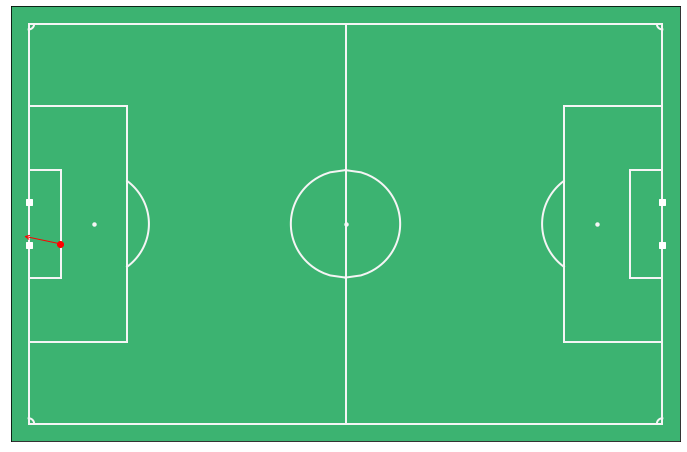

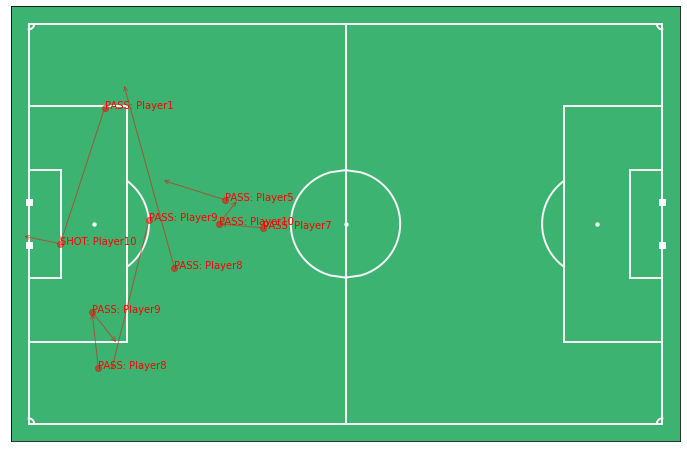

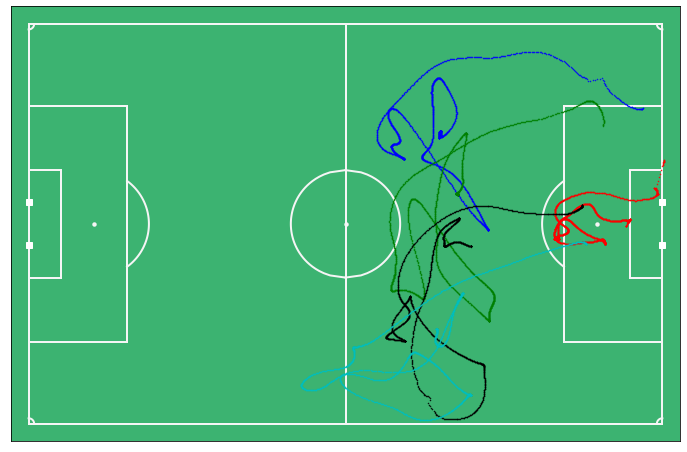

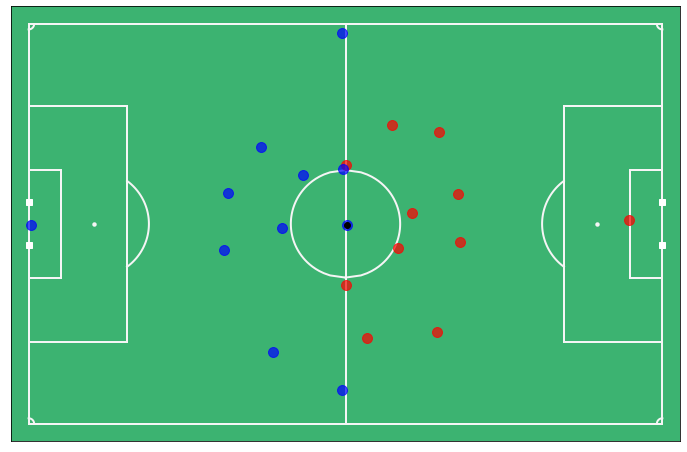

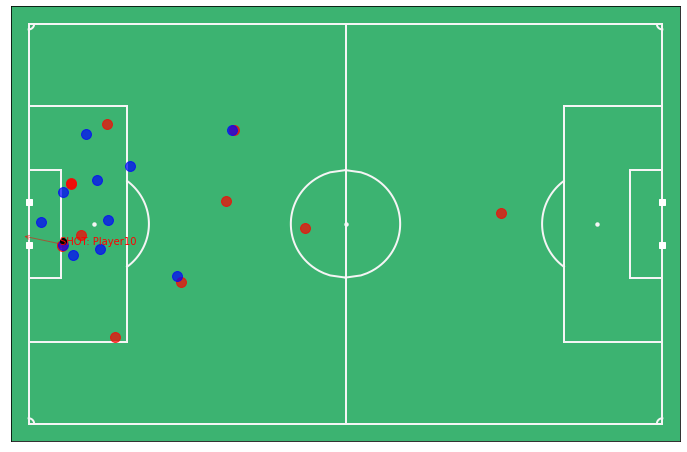

In [0]:

# set up initial path to data
DATADIR = '/gdrive/My Drive/datasets/football/'
game_id = 2 # let's look at sample match 2

# read in the event data
events = read_event_data(DATADIR,game_id)

# count the number of each event type in the data
print( events['Type'].value_counts() )

# Bit of housekeeping: unit conversion from metric data units to meters
events = to_metric_coordinates(events)

# Get events by team
home_events = events[events['Team']=='Home']
away_events = events[events['Team']=='Away']

# Frequency of each event type by team
home_events['Type'].value_counts()
away_events['Type'].value_counts()

# Get all shots
shots = events[events['Type']=='SHOT']
home_shots = home_events[home_events.Type=='SHOT']
away_shots = away_events[away_events.Type=='SHOT']

# Look at frequency of each shot Subtype
home_shots['Subtype'].value_counts()
away_shots['Subtype'].value_counts()

# Look at the number of shots taken by each home player
print( home_shots['From'].value_counts() )

# Get the shots that led to a goal
home_goals = home_shots[home_shots['Subtype'].str.contains('-GOAL')].copy()
away_goals = away_shots[away_shots['Subtype'].str.contains('-GOAL')].copy()

# Add a column event 'Minute' to the data frame
home_goals['Minute'] = home_goals['Start Time [s]']/60.

# Plot the first goal
fig,ax = plot_pitch()
ax.plot( events.loc[198]['Start X'], events.loc[198]['Start Y'], 'ro' )
ax.annotate("", xy=events.loc[198][['End X','End Y']], xytext=events.loc[198][['Start X','Start Y']], alpha=0.6, arrowprops=dict(arrowstyle="->",color='r'))

# plot passing move in run up to goal
plot_events( events.loc[190:198], indicators = ['Marker','Arrow'], annotate=True )

#### TRACKING DATA ####

# READING IN TRACKING DATA
tracking_home =tracking_data(DATADIR,game_id,'Home')
tracking_away = tracking_data(DATADIR,game_id,'Away')

# Look at the column namems
print( tracking_home.columns )

# Convert positions from metrica units to meters 
tracking_home = to_metric_coordinates(tracking_home)
tracking_away =to_metric_coordinates(tracking_away)

# Plot some player trajectories (players 11,1,2,3,4)
fig,ax = plot_pitch()
ax.plot( tracking_home['Home_11_x'].iloc[:1500], tracking_home['Home_11_y'].iloc[:1500], 'r.', MarkerSize=1)
ax.plot( tracking_home['Home_1_x'].iloc[:1500], tracking_home['Home_1_y'].iloc[:1500], 'b.', MarkerSize=1)
ax.plot( tracking_home['Home_2_x'].iloc[:1500], tracking_home['Home_2_y'].iloc[:1500], 'g.', MarkerSize=1)
ax.plot( tracking_home['Home_3_x'].iloc[:1500], tracking_home['Home_3_y'].iloc[:1500], 'k.', MarkerSize=1)
ax.plot( tracking_home['Home_4_x'].iloc[:1500], tracking_home['Home_4_y'].iloc[:1500], 'c.', MarkerSize=1)

# plot player positions at ,atckick-off
KO_Frame = events.loc[0]['Start Frame']
fig,ax = plot_frame( tracking_home.loc[KO_Frame], tracking_away.loc[KO_Frame] )

# PLOT POSTIONS AT GOAL
fig,ax = plot_events( events.loc[198:198], indicators = ['Marker','Arrow'], annotate=True )
goal_frame = events.loc[198]['Start Frame']
fig,ax = plot_frame( tracking_home.loc[goal_frame], tracking_away.loc[goal_frame], figax = (fig,ax) )


## Plot velocity related graphs

Reading team: home
Reading team: away


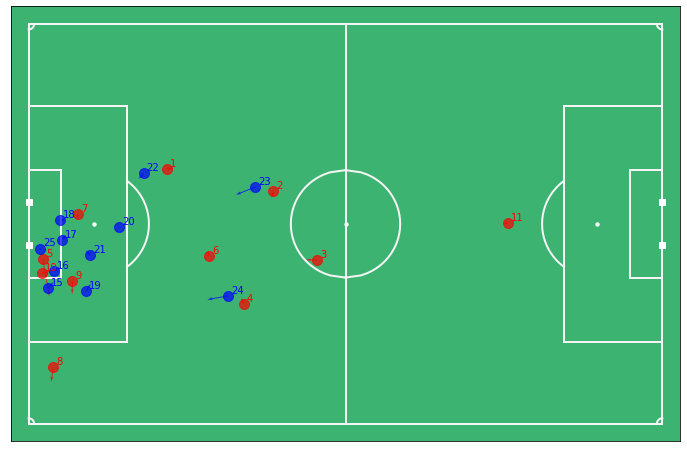

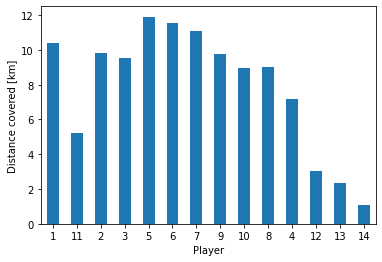

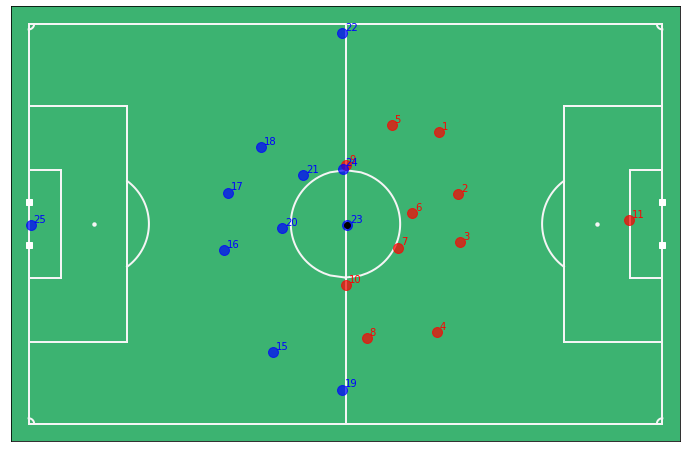

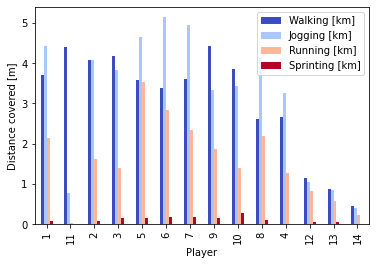

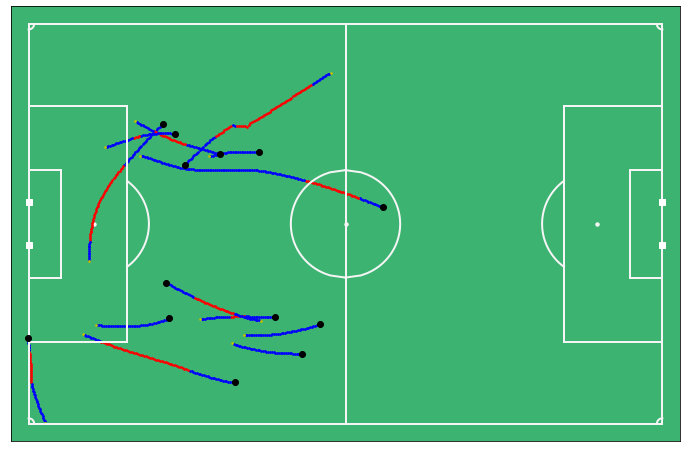

In [0]:
import seaborn as sns
events =read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = tracking_data(DATADIR,game_id,'Home')
tracking_away = tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = to_metric_coordinates(tracking_home)
tracking_away = to_metric_coordinates(tracking_away)
events = to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events =to_single_playing_direction(tracking_home,tracking_away,events)

# Making a movie of the second home team goal
#PLOTDIR = DATADIR
#mviz.save_match_clip(tracking_home.iloc[73600:73600+500],tracking_away.iloc[73600:73600+500],PLOTDIR,fname='home_goal_2',include_player_velocities=False)

# Calculate player velocities
tracking_home = calc_player_velocities(tracking_home,smoothing=True)
tracking_away = calc_player_velocities(tracking_away,smoothing=True)

# plot a random frame, plotting the player velocities using quivers
plot_frame( tracking_home.loc[10000], tracking_away.loc[10000], include_player_velocities=True, annotate=True)

# Create a Physical summary dataframe for home players
home_players = np.unique( [ c.split('_')[1] for c in tracking_home.columns if c[:4] == 'Home' ] )
home_summary = pd.DataFrame(index=home_players)

# Calculate minutes played for each player
minutes = []
for player in home_players:
    # search for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
    column = 'Home_' + player + '_x' # use player x-position coordinate
    player_minutes = ( tracking_home[column].last_valid_index() - tracking_home[column].first_valid_index() + 1 ) / 25 / 60. # convert to minutes
    minutes.append( player_minutes )
home_summary['Minutes Played'] = minutes
home_summary = home_summary.sort_values(['Minutes Played'], ascending=False)

# Calculate total distance covered for each player
distance = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_distance = tracking_home[column].sum()/25./1000 # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance.append( player_distance )
home_summary['Distance [km]'] = distance

# make a simple bar chart of distance covered for each player
plt.subplots()
ax = home_summary['Distance [km]'].plot.bar(rot=0)
ax.set_xlabel('Player')
ax.set_ylabel('Distance covered [km]')

# plot positions at KO (to find out what position each player is playing)
plot_frame( tracking_home.loc[51], tracking_away.loc[51], include_player_velocities=False, annotate=True)

# now calculate distance covered while: walking, joggings, running, sprinting
walking = []
jogging = []
running = []
sprinting = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_home.loc[tracking_home[column] < 2, column].sum()/25./1000
    walking.append( player_distance )
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 2) & (tracking_home[column] < 4), column].sum()/25./1000
    jogging.append( player_distance )
    # running (between 4 and 7 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 4) & (tracking_home[column] < 7), column].sum()/25./1000
    running.append( player_distance )
    # sprinting (greater than 7 m/s)
    player_distance = tracking_home.loc[ tracking_home[column] >= 7, column].sum()/25./1000
    sprinting.append( player_distance )
    
home_summary['Walking [km]'] = walking
home_summary['Jogging [km]'] = jogging
home_summary['Running [km]'] = running
home_summary['Sprinting [km]'] = sprinting

# make a clustered bar chart of distance covered for each player at each speed
ax = home_summary[['Walking [km]','Jogging [km]','Running [km]','Sprinting [km]']].plot.bar(colormap='coolwarm')
ax.set_xlabel('Player')
ax.set_ylabel('Distance covered [m]')

# sustained sprints: how many sustained sprints per match did each player complete? Defined as maintaining a speed > 7 m/s for at least 1 second
nsprints = []
sprint_threshold = 7 # minimum speed to be defined as a sprint (m/s)
sprint_window = 1*25 # minimum duration sprint should be sustained (in this case, 1 second = 25 consecutive frames)
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # trick here is to convolve speed with a window of size 'sprint_window', and find number of occassions that sprint was sustained for at least one window length
    # diff helps us to identify when the window starts
    player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
    nsprints.append( np.sum( player_sprints == 1 ) )
home_summary['# sprints'] = nsprints
         
# Plot the trajectories for each of player 10's sprints
player = '10'
column = 'Home_' + player + '_speed' # spped
column_x = 'Home_' + player + '_x' # x position
column_y = 'Home_' + player + '_y' # y position
# same trick as before to find start and end indices of windows of size 'sprint_window' in which player speed was above the sprint_threshold
player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
player_sprints_start = np.where( player_sprints == 1 )[0] - int(sprint_window/2) + 1 # adding sprint_window/2 because of the way that the convolution is centred
player_sprints_end = np.where( player_sprints == -1 )[0] + int(sprint_window/2) + 1
# now plot all the sprints
fig,ax = plot_pitch()
for s,e in zip(player_sprints_start,player_sprints_end):
    ax.plot(tracking_home[column_x].iloc[s],tracking_home[column_y].iloc[s],'ko')
    """g = sns.scatterplot(x=tracking_home[column_x].iloc[s:e+1], y=tracking_home[column_y].iloc[s:e+1], 
                         hue=tracking_home[column].iloc[s:e+1],data=tracking_home,legend="brief")"""
    for i in range(s,e+1):
      col='w'
      if tracking_home[column].iloc[i]>=6 and tracking_home[column].iloc[i]<7:
        col='y'
      elif tracking_home[column].iloc[i]>=7 and tracking_home[column].iloc[i]<8:
        col='b'
      elif tracking_home[column].iloc[i]>=8:
        col='r'
      
      #ax.plot(tracking_home[column_x].iloc[i],tracking_home[column_y].iloc[i],color=col)
      ax.scatter(tracking_home[column_x].iloc[i], tracking_home[column_y].iloc[i], c=col,s=3)

In [0]:
events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44


In [0]:
hometeam=tracking_home[20:24].reset_index()
hometeam

,Frame,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,Home_4_x,Home_4_y,Home_5_x,Home_5_y,Home_6_x,Home_6_y,Home_7_x,Home_7_y,Home_8_x,Home_8_y,Home_9_x,Home_9_y,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y,Home_1_vx,Home_1_vy,Home_1_speed,Home_10_vx,Home_10_vy,Home_10_speed,Home_11_vx,Home_11_vy,Home_11_speed,Home_12_vx,Home_12_vy,Home_12_speed,Home_13_vx,Home_13_vy,Home_13_speed,Home_14_vx,Home_14_vy,Home_14_speed,Home_2_vx,Home_2_vy,Home_2_speed,Home_3_vx,Home_3_vy,Home_3_speed,Home_4_vx,Home_4_vy,Home_4_speed,Home_5_vx,Home_5_vy,Home_5_speed,Home_6_vx,Home_6_vy,Home_6_speed,Home_7_vx,Home_7_vy,Home_7_speed,Home_8_vx,Home_8_vy,Home_8_speed,Home_9_vx,Home_9_vy,Home_9_speed
0,21,1,0.84,47.35656,0.39508,15.57564,14.88724,18.81712,4.89396,20.54174,-3.72844,15.34350,-17.90372,-29.73936,16.39888,10.88514,1.77004,8.87326,-4.54172,3.19484,-19.24876,0.27242,9.98172,0.05088,-10.54612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.098429,0.451714,0.462314,0.037857,-0.252571,0.255393,0.465643,0.794143,0.920590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.166000,0.468714,1.256682,0.109786,-0.191857,0.221048,NaN,NaN,NaN,0.0,0.0,0.0,0.151429,0.332714,0.365554,0.336929,-0.340000,0.478666,0.003786,-0.381286,0.381305
1,22,1,0.88,47.37034,0.42228,15.57352,14.90356,18.81712,4.89396,20.49404,-3.70872,15.34986,-17.90712,-29.81250,16.39820,10.88514,1.77004,8.87856,-4.52880,3.20756,-19.26236,0.27560,9.97968,0.05406,-10.55020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.056786,0.505143,0.508325,0.053000,-0.155429,0.164216,0.427786,0.748000,0.861687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.147071,0.517286,1.258315,0.113571,-0.211286,0.239875,NaN,NaN,NaN,0.0,0.0,0.0,0.117357,0.349714,0.368880,0.321786,-0.330286,0.461123,0.022714,-0.315714,0.316530
2,23,1,0.92,47.38306,0.44744,15.57246,14.91988,18.81712,4.89396,20.44952,-3.68220,15.35516,-17.91392,-23.53200,16.44172,10.88514,1.77004,8.88280,-4.50976,3.21922,-19.27460,0.27772,9.96608,0.05618,-10.55224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.026500,0.534286,0.534942,0.060571,-0.065571,0.089267,0.405071,0.716429,0.823014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.135714,0.519714,1.248980,0.109786,-0.230714,0.255503,NaN,NaN,NaN,0.0,0.0,0.0,0.087071,0.388571,0.398207,0.310429,-0.315714,0.442766,0.041643,-0.269571,0.272769
3,24,1,0.96,47.40002,0.47532,15.57140,14.93688,18.81712,4.89396,20.40394,-3.66044,15.35834,-17.92344,-17.24302,16.48524,10.88514,1.77004,8.88386,-4.49412,3.23088,-19.28820,0.27984,9.95588,0.05830,-10.55156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011357,0.556143,0.556259,0.068143,0.026714,0.073192,0.382357,0.687286,0.786485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.120571,0.534286,1.241427,0.094643,-0.259857,0.276556,NaN,NaN,NaN,0.0,0.0,0.0,0.056786,0.415286,0.419150,0.302857,-0.313286,0.435741,0.053000,-0.204000,0.210772


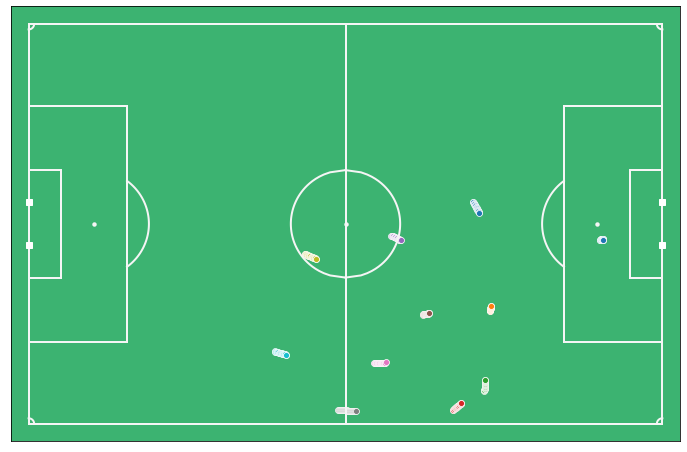

In [0]:
import seaborn as sns
fig,ax = plot_pitch()

#plt.scatter(x_loc, y_loc, c=marker_colour, edgecolors='k', zorder=12, alpha=0.75)
for i in range(1,12):
  sns.scatterplot(tracking_home['Home_'+str(i)+'_x'].iloc[600:620], tracking_home['Home_'+str(i)+'_y'].iloc[600:620])

In [0]:
tracking_home.head()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,Home_4_x,Home_4_y,Home_5_x,Home_5_y,Home_6_x,Home_6_y,Home_7_x,Home_7_y,Home_8_x,Home_8_y,Home_9_x,Home_9_y,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y,Home_1_vx,Home_1_vy,Home_1_speed,Home_10_vx,Home_10_vy,Home_10_speed,Home_11_vx,Home_11_vy,Home_11_speed,Home_12_vx,Home_12_vy,Home_12_speed,Home_13_vx,Home_13_vy,Home_13_speed,Home_14_vx,Home_14_vy,Home_14_speed,Home_2_vx,Home_2_vy,Home_2_speed,Home_3_vx,Home_3_vy,Home_3_speed,Home_4_vx,Home_4_vy,Home_4_speed,Home_5_vx,Home_5_vy,Home_5_speed,Home_6_vx,Home_6_vy,Home_6_speed,Home_7_vx,Home_7_vy,Home_7_speed,Home_8_vx,Home_8_vy,Home_8_speed,Home_9_vx,Home_9_vy,Home_9_speed
Frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.26066,16.40908,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.26066,16.40908,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.26066,16.40908,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.35076,16.40840,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.43980,16.40772,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.5635,-0.012143,1.563547,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
X=tracking_home.iloc[0:100,2:24]

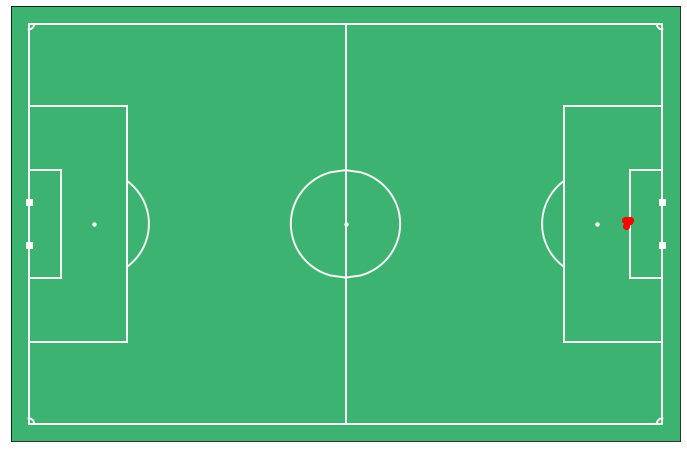

In [0]:
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=11, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
fig,ax = plot_pitch()
ax.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],'ro')

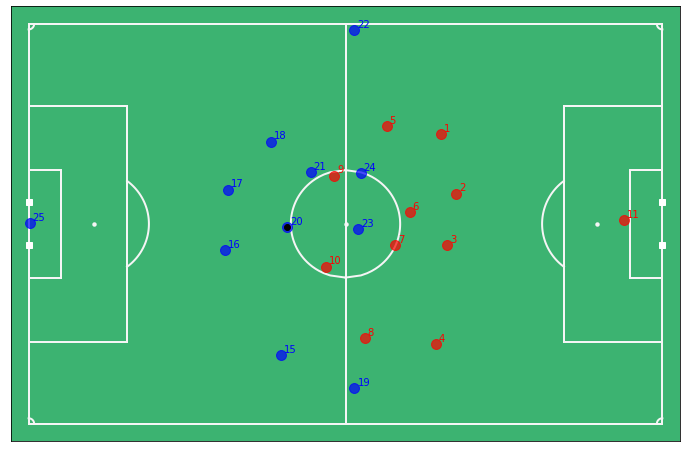

In [0]:
fig,ax=plot_frame(tracking_home.loc[100], tracking_away.loc[100],
                  include_player_velocities=False, annotate=True)

## Voronoi Plot

In [0]:
from scipy.spatial import Voronoi, voronoi_plot_2d
def voronoi_plot(ind,tracking_home,tracking_away):
  
  h_xs = tracking_home[[c for c in tracking_home.columns if 'H' in c and '_x' in c and 'vx' not in c and 'vy' not in c and 'speed' not in c]].iloc[ind].values
  h_ys = tracking_home[[c for c in tracking_home.columns if 'H' in c and '_y' in c and 'vx' not in c and 'vy' not in c and 'speed' not in c]].iloc[ind].values
  a_xs = tracking_away[[c for c in tracking_away.columns if 'A' in c and '_x' in c and 'vx' not in c and 'vy' not in c and 'speed' not in c]].iloc[ind].values
  a_ys = tracking_away[[c for c in tracking_away.columns if 'A' in c and '_y' in c and 'vx' not in c and 'vy' not in c and 'speed' not in c]].iloc[ind].values
  h_xs = h_xs[~np.isnan(h_xs)]
  a_xs = a_xs[~np.isnan(a_xs)]
  h_ys = h_ys[~np.isnan(h_ys)]
  a_ys = a_ys[~np.isnan(a_ys)]
  xs=np.concatenate((h_xs,a_xs)) 
  ys=np.concatenate((h_ys,a_ys)) 
  ps = [(x,y) for x,y in zip(xs, ys)]
  max_w,max_h=106,68
  extended_ps = (ps +
                  [(-106-p[0], p[1]) for p in ps] +       #Reflection in left touchline
                  [(p[0], -68-p[1]) for p in ps] +       #Reflection in bottom touchline
                  [(106-p[0], p[1]) for p in ps]+ #Reflection in right touchline
                  [(p[0], 68-p[1]) for p in ps]  #Relfection in top touchline
                )
  vor = Voronoi(extended_ps)
  fib=[]
  fig,ax = plot_pitch(field_color ='white')
  for pix, p in enumerate(vor.points):                #Each polygon in the VT has a corresponding point
      region = vor.regions[vor.point_region[pix]]     #That point corresponds to a region

      if not -1 in region:                            #-1 is a point at infinity, we don't need those polygons
          polygon = [vor.vertices[i] for i in region] #The region polygon as a list of points
          if p[0] in xs and p[1] in ys:
              if p[0] in a_xs and p[1] in a_ys:
                  plt.fill(*zip(*polygon), alpha=0.2, c='xkcd:pale red')
              else:
                  plt.fill(*zip(*polygon), alpha=0.2, c='xkcd:denim blue')

  #Add in the player points
  voronoi_plot_2d(vor, ax, show_vertices=False, show_points=False)##
  objs=ax.scatter(h_xs, h_ys, c='xkcd:denim blue', s=90.)
  objs=ax.scatter(a_xs, a_ys, c='xkcd:pale red', s=90.)
  fib.append(objs)
  objs=ax.scatter(tracking_home.iloc[ind].ball_x, tracking_home.iloc[ind].ball_y, c='xkcd:grey', s=90.)
  fib.append(objs)
  frame_minute =  int( tracking_home.iloc[ind]['Time [s]']/60. )
  frame_second =  ( tracking_home.iloc[ind]['Time [s]']/60. - frame_minute ) * 60.
  timestring = "%d:%1.2f" % ( frame_minute, frame_second  )
  objs = ax.text(-2.5,max_h/2.+2., timestring, fontsize=14 )
  plt.xlim(-54,54)#-54to54
  plt.ylim(-35,35)#-35to35
  plt.savefig("/gdrive/My Drive/images/"+str(i)+".png")
  #print(plt)
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  return data

In [0]:
import cv2
import os
image_folder = '/gdrive/My Drive/images/'
video_name = '/gdrive/My Drive/images/video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
out = cv2.VideoWriter(video_name, fourcc, 20.0, (width, height))
for i in range(200,250):
  data=voronoi_plot(i,tracking_home,tracking_away)
  out.write(data) # Write out frame to video

# Release everything if job is finished
out.release()
cv2.destroyAllWindows()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(864, 576)
(864, 576)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


## Pitch Control

In [0]:
game_id = 2 # let's look at sample match 2

# read in the event data
events = read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home =tracking_data(DATADIR,game_id,'Home')
tracking_away = tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = to_metric_coordinates(tracking_home)
tracking_away = to_metric_coordinates(tracking_away)
events = to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = calc_player_velocities(tracking_home,smoothing=True)
tracking_away =calc_player_velocities(tracking_away,smoothing=True)

Reading team: home
Reading team: away


      Team  Type              Subtype  Period  ...  Start X  Start Y  End X  End Y
198   Home  SHOT       ON TARGET-GOAL       1  ...   -47.70    -3.40 -54.06  -2.04
823   Away  SHOT       ON TARGET-GOAL       1  ...    44.52     2.72  54.06   1.36
1118  Home  SHOT  HEAD-ON TARGET-GOAL       2  ...   -47.70     1.36 -54.06   2.04
1671  Away  SHOT       ON TARGET-GOAL       2  ...    40.28     1.36  55.12   2.72
1723  Home  SHOT       ON TARGET-GOAL       2  ...   -30.74     5.44 -54.06   2.72

[5 rows x 14 columns]
Event following a risky (completed) pass
0.26455950351294005 CHALLENGE
0.28505234723760897 BALL LOST
0.3006628396711591 SHOT
0.31160841865474626 CHALLENGE
0.33704347298090714 CHALLENGE
0.3913125864694877 SHOT
0.4188148605128081 BALL LOST
0.4194468674048554 CHALLENGE
0.4204267746341931 PASS
0.4312712628523871 CHALLENGE
0.44436475742157466 CHALLENGE
0.44844895551994096 PASS
0.4593665151483775 CHALLENGE
0.4635633533167435 SHOT
0.468048170879984 CHALLENGE
0.4897275563912591 CHAL

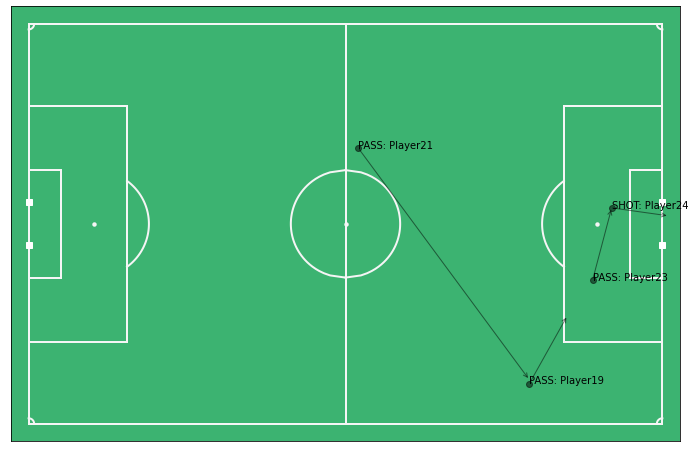

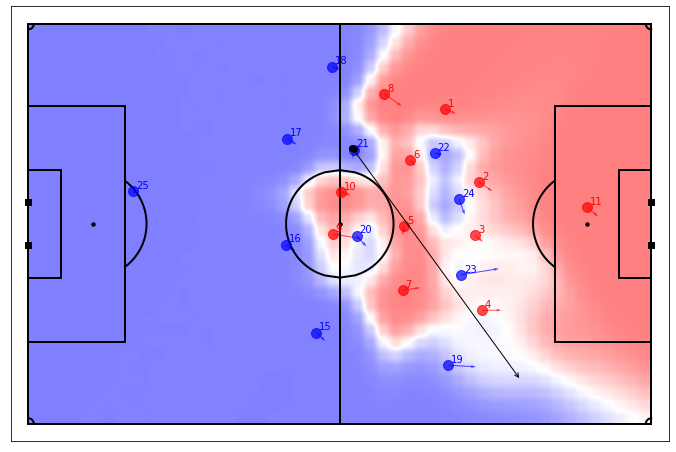

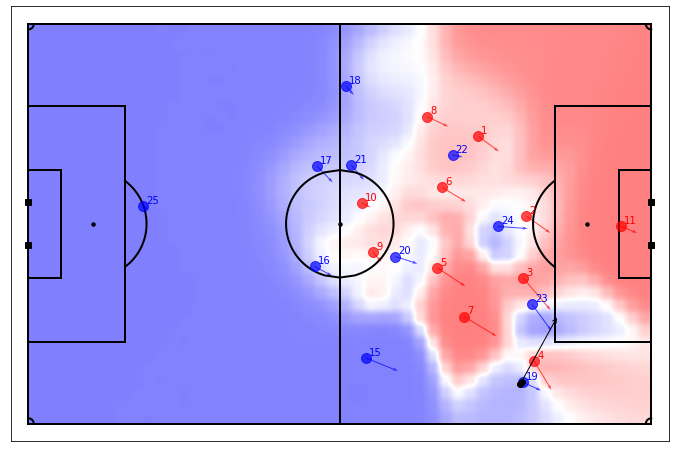

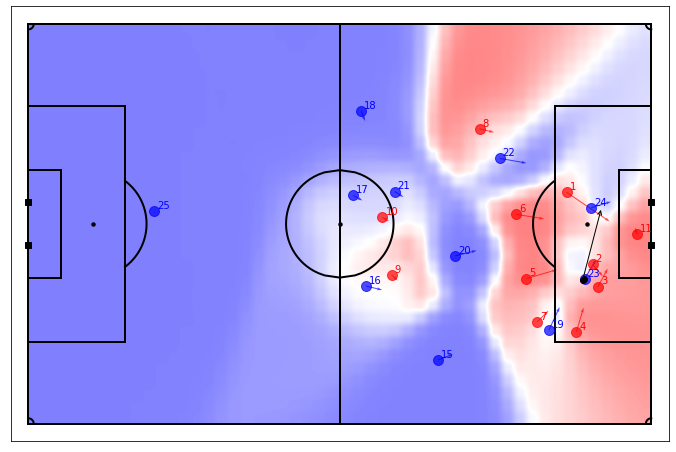

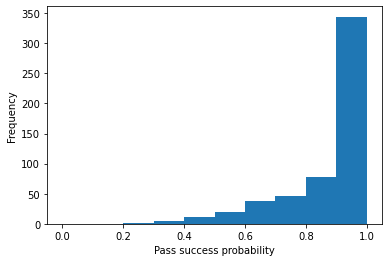

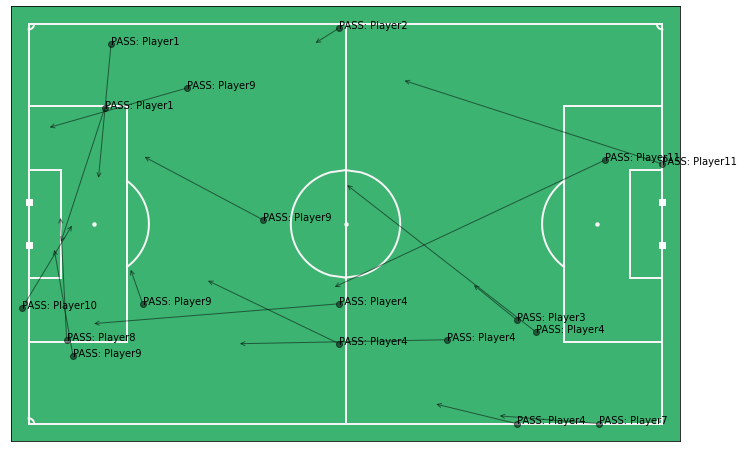

In [0]:

shots = events[events['Type']=='SHOT']
goals = shots[shots['Subtype'].str.contains('-GOAL')].copy()

print(goals)

plot_events( events.loc[820:823], color='k', indicators = ['Marker','Arrow'], annotate=True )

# first get model parameters
params = default_model_params(3)

# evaluated pitch control surface for first pass
PPCF,xgrid,ygrid = generate_pitch_control_for_event(820, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
plot_pitchcontrol_for_event( 820, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )
# evaluated pitch control surface for second pass
PPCF,xgrid,ygrid = generate_pitch_control_for_event(821, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
plot_pitchcontrol_for_event( 821, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )
# evaluated pitch control surface for third pass
PPCF,xgrid,ygrid = generate_pitch_control_for_event(822, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
plot_pitchcontrol_for_event( 822, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )

""" **** calculate pass probability for every home team succesful pass **** """
# get all home passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]

# list for storing pass probablities
pass_success_probability = []

for i,row in home_passes.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = initialise_players(tracking_home.loc[pass_frame],'Home',params)
    defending_players = initialise_players(tracking_away.loc[pass_frame],'Away',params)
    Patt,Pdef = calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

    pass_success_probability.append( (i,Patt) )
    
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  

# sort the passes by pitch control probability
pass_success_probability = sorted( pass_success_probability, key = lambda x: x[1] )

# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_passes = events.loc[ [p[0] for p in pass_success_probability if p[1]<0.5 ] ]

# plot the events
plot_events( risky_passes, color='k', indicators = ['Marker','Arrow'], annotate=True )

# Print events that followed those risky passes
print("Event following a risky (completed) pass")
for p in pass_success_probability[:20]:
    outcome = events.loc[ p[0]+1 ].Type
    print( p[1], outcome )

